In [1]:
import torch
from torch import nn

import math
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as display
from IPython.display import clear_output
import sys
import time
import datetime
import os


torch.manual_seed(111)

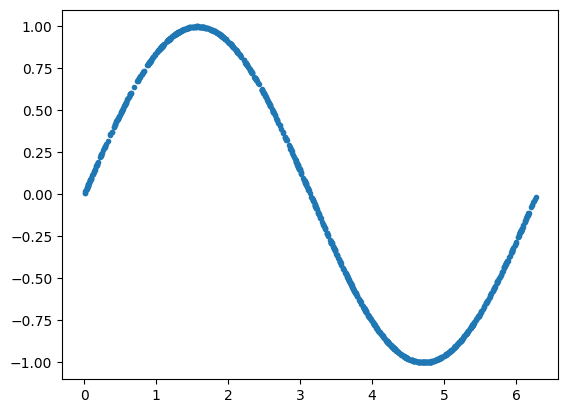

In [2]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ELU(),
            nn.Linear(16, 32),
            nn.ELU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output


discriminator = Discriminator()
generator = Generator()

In [5]:
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()
# optimizer_discriminator = torch.optim.SGD(discriminator.parameters(), lr=0.001, weight_decay=1e-3)
# optimizer_generator = torch.optim.SGD(generator.parameters(), lr=0.001, weight_decay=1e-3)

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, weight_decay=1e-4)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, weight_decay=1e-4)

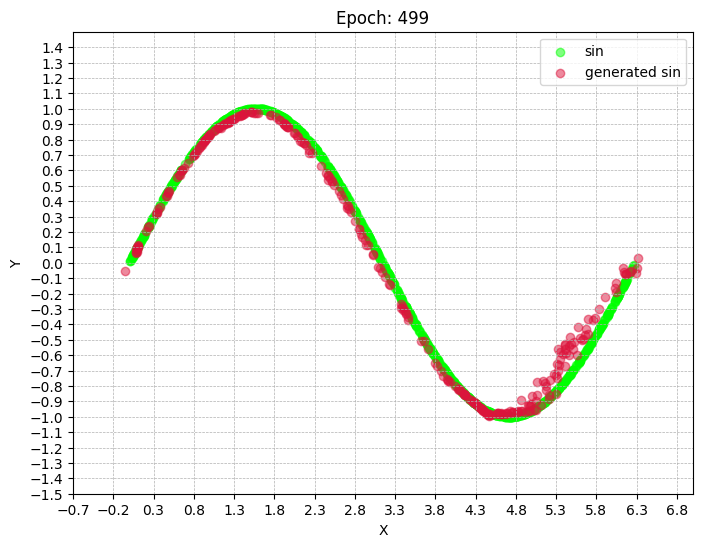

Epoch: 499 Loss D.: 0.6204 Loss G.: 0.9448


In [6]:
output_dir = datetime.datetime.now().strftime("SIN-GAN-EVO_%Y-%m-%d_%H-%M-%S")
os.makedirs(output_dir, exist_ok=True)

evolution_samples = torch.randn(100, 2)
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))

        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))

        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))


        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Обучение генератора
        latent_space_samples = torch.randn((batch_size, 2))
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)

        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        loss_generator.backward()
        optimizer_generator.step()

        latent_space_samples = torch.randn(100, 2)
        generated_samples = generator(latent_space_samples)
        generated_samples = generated_samples.detach()

    if epoch % 1 == 0 and n == batch_size - 1:
        clear_output(wait=True)
        generated_samples = generator(evolution_samples)
        generated_samples = generated_samples.detach()
        plt.figure(figsize=(8, 6))

        plt.scatter(train_data[:, 0], train_data[:, 1],
            color='lime',
            alpha=0.5,
            label="sin"
        )
        plt.scatter(generated_samples[:, 0], generated_samples[:, 1],
            color='crimson',
            alpha=0.5,
            label="generated sin"
        )

        plt.legend()
        plt.title(f"Epoch: {epoch}")
        plt.xlabel("X")
        plt.ylabel("Y")

        plt.xlim(-0.7, 7)
        plt.ylim(-1.5, 1.5)
        plt.grid(which='both', linestyle='--', linewidth=0.5)
        plt.xticks(np.arange(-0.7, 7, 0.5))
        plt.yticks(np.arange(-1.5, 1.5, 0.1))

        plt.savefig(f"{output_dir}/{epoch}.png")
        plt.show()

        # Распечатываем текущие значения
        print(f"Epoch: {epoch} Loss D.: {loss_discriminator:.4f} Loss G.: {loss_generator:.4f}")